<a href="https://colab.research.google.com/github/prashantmalan/TradingStrategies/blob/main/meanReversion/mean_reversion_strategy_on_ewa_and_ewc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Arbitrage Strategy- Mean Reversion: A Functional Overview

## Objective
The primary objective of the Statistical Arbitrage Strategy is to identify and exploit inefficiencies in the pricing of financial instruments, specifically through pairs trading. This strategy involves finding pairs of assets that move together in a statistically significant manner and taking advantage of temporary deviations in their price relationship.

## Key Components

### Pair Identification

- **Co-integration**: The first step is to identify pairs of assets that are co-integrated. Co-integration means that the price series of the two assets move together over time, even if they may drift apart temporarily. This is crucial because it implies a long-term equilibrium relationship between the assets.
- **Statistical Tests**: Techniques such as the Augmented Dickey-Fuller (ADF) test and the Engle-Granger two-step method are used to test for co-integration.

### Entry and Exit Points

- **Z-Score**: The z-score is used to measure how many standard deviations away the current price difference (spread) between the two assets is from its mean. A high positive z-score indicates that the spread is unusually large, suggesting a potential short position on the outperforming asset and a long position on the underperforming asset. Conversely, a low negative z-score indicates a potential long position on the underperforming asset and a short position on the outperforming asset.
- **Bollinger Bands**: These are used to identify entry and exit points based on the volatility of the spread. When the spread crosses above the upper Bollinger Band, it may indicate a short position, and when it crosses below the lower Bollinger Band, it may indicate a long position.

### Position Sizing and Risk Management

- **Risk Management**: Proper risk management is essential to ensure that the strategy does not result in significant losses. This includes setting stop-loss orders and monitoring the overall portfolio risk.
- **Position Sizing**: The size of the positions taken in each asset is determined based on the volatility of the spread and the risk tolerance of the trader. This ensures that the positions are balanced and that the risk is spread evenly across the portfolio.

### Back-testing

- **Historical Data**: The strategy is back-tested using historical data to evaluate its performance over time. This involves simulating trades based on historical price data and analyzing the results.
- **Performance Metrics**: Key performance metrics such as the Sharpe ratio, maximum drawdown, and annualized return are used to assess the effectiveness of the strategy.

## Practical Implementation

### Data Collection

- Collect historical price data for the assets you are interested in. This data can be obtained from financial data providers or online sources.

### Data Analysis

- Use statistical tools and libraries (e.g., `statsmodels` in Python) to perform co-integration tests and calculate the z-score and Bollinger Bands.

### Trade Execution

- Implement the strategy in a trading platform or a custom script that can execute trades based on the signals generated by the strategy.

### Monitoring and Adjustment

- Continuously monitor the performance of the strategy and make adjustments as necessary. This may involve re-evaluating the co-integration relationship, updating the z-score thresholds, or adjusting the position sizes.

WA and EWC are both exchange-traded funds (ETFs) that track different indices and are often used in pairs trading strategies due to their cointegration properties.

##EWA (iShares MSCI Australia ETF):
This ETF tracks the performance of the Australian equity market by investing in stocks from various sectors in Australia. It is often used as a representative of the Australian economy and its stock market.

##EWC (iShares MSCI Canada ETF
 This ETF tracks the performance of the Canadian equity market by investing in stocks from various sectors in Canada. It is used as a representative of the Canadian economy and its stock market.

These two ETFs are frequently mentioned in the context of pairs trading because they exhibit cointegration, meaning their price series move together over time in a statistically significant manner. This cointegration allows traders to implement a pairs trading strategy, where they can take advantage of temporary deviations in the price relationship between EWA and EWC by buying one and selling the other, expecting the prices to converge back to their long-term equilibrium relationsh

## Lets get hands dirty

In [ ]:
import numpy as np
import pandas as pd
import plotly.io as pio
pio.renderers.default = 'iframe'
import warnings
warnings.simplefilter("ignore")

# Mean Reversion Strategy on EWA and EWC

This block loads historical price data for the EWA and EWC assets from specified URLs. The data is read into pandas DataFrames, with the 'Close' prices extracted. The two DataFrames are then concatenated into a single DataFrame df, which is indexed by date

In [ ]:
EFS_EWA = r'https://raw.githubusercontent.com/prashantmalan/TradingStrategies/main/EFSStrategies/EFS_EWA.csv'
EFS_EWC = r'https://raw.githubusercontent.com/prashantmalan/TradingStrategies/main/EFSStrategies/EFS_EWC.csv' # Changed variable name to EFS_EWC

x = pd.read_csv(EFS_EWA, index_col=0)['Close'] # Now reading from the correct URL for EWA
y = pd.read_csv(EFS_EWC, index_col=0)['Close'] # Now reading from the correct URL for EWC

In [ ]:
df = pd.concat([x,y],axis=1)
df.columns = ['EWA','EWC']
df.index = pd.to_datetime(df.index)

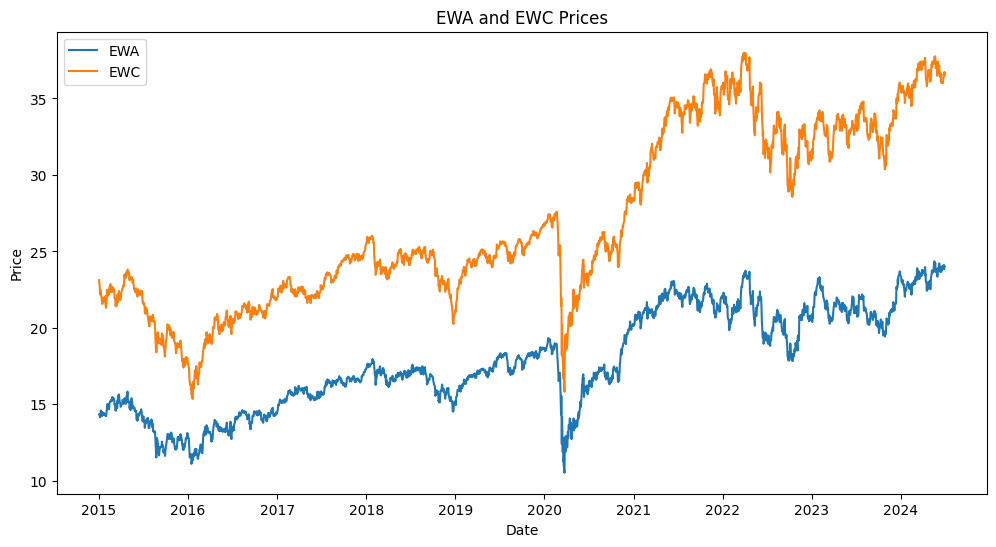

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['EWA'], label='EWA')
plt.plot(df.index, df['EWC'], label='EWC')
plt.title('EWA and EWC Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

This block uses the Ordinary Least Squares (OLS) method from the statsmodels library to fit a linear regression model between EWC and EWA for the first 90 data points. The spread is then calculated as the difference between the actual EWC prices and the predicted values based on the EWA price

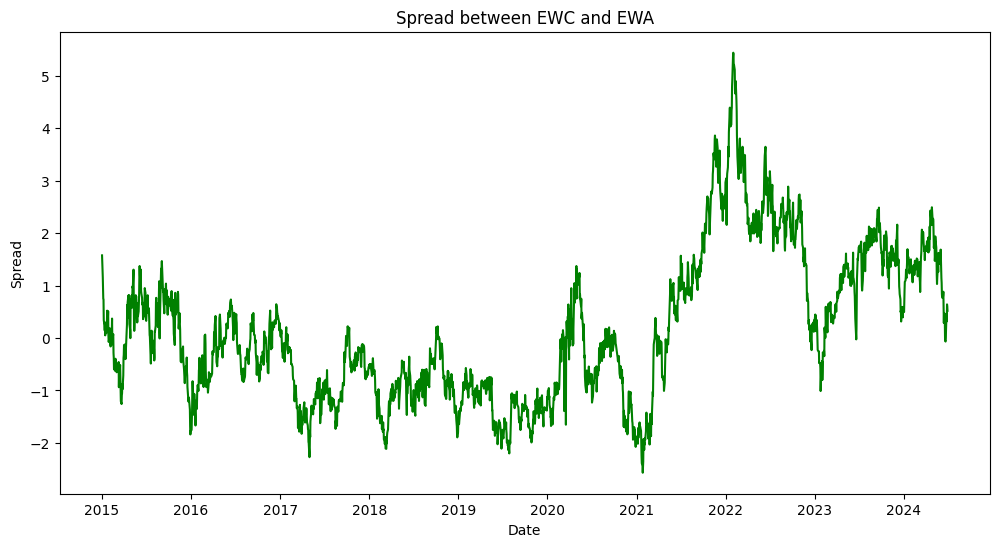

In [ ]:
from statsmodels.api import OLS
import matplotlib.pyplot as plt

# Fit the OLS model
model = OLS(df.EWC.iloc[:90], df.EWA.iloc[:90])
model = model.fit()

# Calculate the spread
df['spread'] = df.EWC - model.params.iloc[0] * df.EWA

# Plot the spread using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['spread'], color='green')
plt.title('Spread between EWC and EWA')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

## Mean reversion strategy function



This function implements the mean reversion strategy. It calculates the moving average and standard deviation of the spread over a specified lookback period. Upper and lower bands are established to identify entry and exit points for long and short positions. The function updates the DataFrame with the calculated positions based on the conditions defined

In [ ]:
def mean_reversion_strategy(df, lookback, std_dev):

    # Moving Average
    df['moving_average'] = df.spread.rolling(lookback).mean()
    # Moving Standard Deviation
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    # Upper band and lower band
    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    # Long positions
    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average

    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.ffill()

    # Short positions
    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average

    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0

    df.positions_short = df.positions_short.ffill()

    # Positions
    df['positions'] = df.positions_long + df.positions_short

    return df

In [ ]:
df = mean_reversion_strategy(df, 30, 2)

## Cumulative returns

In this block, the strategy's performance is evaluated by calculating the percentage change in the spread and the resulting strategy returns. Cumulative returns are computed, and the total returns are printed. The Sharpe Ratio is also calculated to assess the risk-adjusted return of the strategy. Finally, a plot of cumulative returns is displayed

In [ ]:
df['percentage_change'] = (df.spread - df.spread.shift(1))/(model.params[0]*df.EWA + 1 * df.EWC)
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
"The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100)

'The total strategy returns are 51.10'

In [ ]:
s = np.mean(df['strategy_returns'])/np.std(df['strategy_returns'])*(252**0.5)
'The Sharpe Ratio %.2f' % s

'The Sharpe Ratio 1.01'

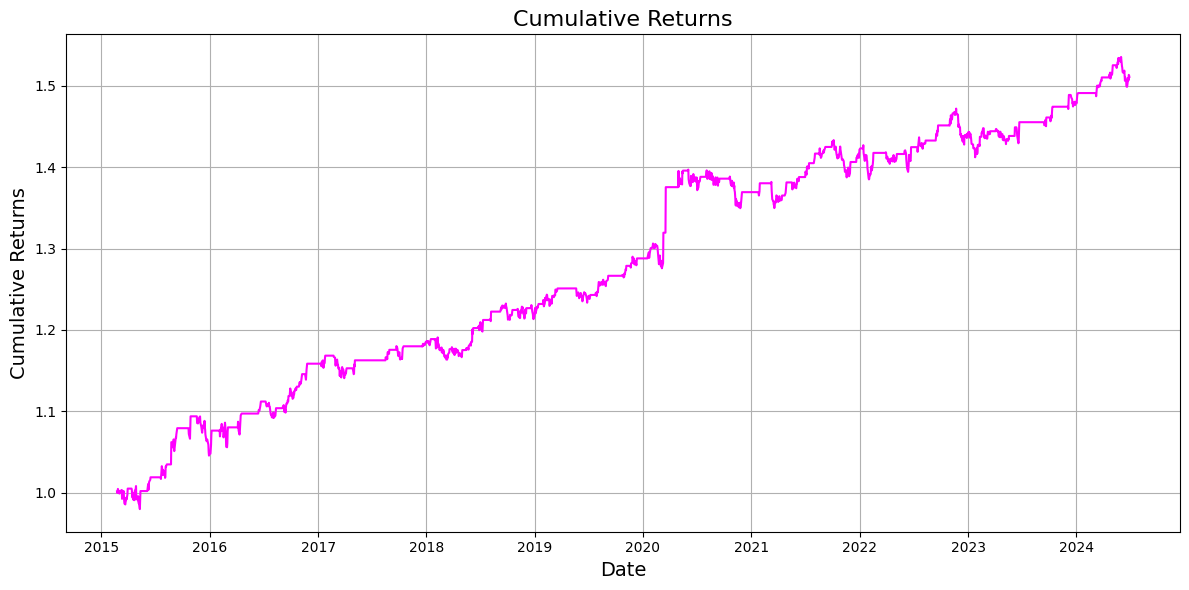

In [ ]:
import matplotlib.pyplot as plt

# Plot the cumulative returns using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_returns'], color='magenta')
plt.title('Cumulative Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

This block defines two functions for calculating and plotting drawdowns. The calc_drawdown function computes the maximum drawdown from the cumulative returns, while the plot_drawdown function visualizes the drawdown over time. The area under the drawdown curve is shaded to indicate the magnitude of the drawdow

The maximum drawdown is -4.41%


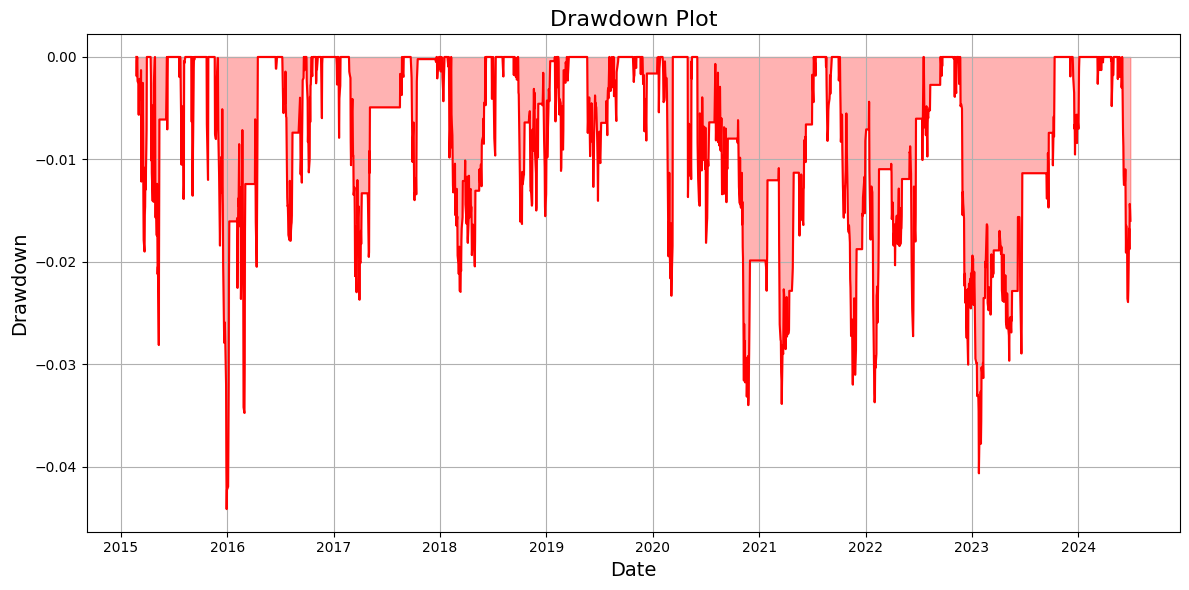

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets) / running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    # Plot the drawdown using Matplotlib
    plt.figure(figsize=(12, 6))
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.plot(drawdown.index, drawdown, color='red')
    plt.title('Drawdown Plot', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Drawdown', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
drawdown = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f%%" % (drawdown.min() * 100))
plot_drawdown(drawdown)